# Hybrid Model 01: Sjednocení modelů (Models integration)

In [1]:
# Instalace potřebných knihoven
#%pip install pandas
#%pip install numpy
#%pip install seaborn matplotlib

In [2]:
# Import potřebných knihoven
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

### Vstupní data

In [3]:
### Deterministická data

# Soubor je načten a přiřazen do proměnné ‚df_cycl‘
other_path = '../../data/02_DetermModel/model_data.csv'
df_cycl = pd.read_csv(other_path, header=0)
df_cycl

,x,y,z,dist,total_time
0,74,459,1284,2036.347957,39.408400
1,-90,4908,2217,2706.465038,42.332379
2,522,3074,26,1374.058223,36.518575
3,425,2247,2739,1504.644476,37.088373
4,516,3425,1590,1032.705670,35.029123
...,...,...,...,...,...
19995,3122,589,704,3261.337302,44.753500
19996,1693,319,1561,2461.936433,41.265407
19997,2078,-4,46,3156.234465,44.294896
19998,3151,317,2282,3555.631308,46.037618


### Generování časové trajektorie deterministické doby cyklu

In [4]:
# Zaokrouhlení hodnot, převod na int a vytvoření čísla cyklu z indexu
df_cycl['total_time'] = df_cycl['total_time'].round().astype(int)
df_cycl['dist'] = df_cycl['dist'].round().astype(int)
df_cycl['cycle'] = df_cycl.index + 1
df_cycl

,x,y,z,dist,total_time,cycle
0,74,459,1284,2036,39,1
1,-90,4908,2217,2706,42,2
2,522,3074,26,1374,37,3
3,425,2247,2739,1505,37,4
4,516,3425,1590,1033,35,5
...,...,...,...,...,...,...
19995,3122,589,704,3261,45,19996
19996,1693,319,1561,2462,41,19997
19997,2078,-4,46,3156,44,19998
19998,3151,317,2282,3556,46,19999


In [5]:
# Rozbalení řádků s vytvořením průběžného času
df_cycl_time = (
    df_cycl.loc[df_cycl.index.repeat(df_cycl['total_time']), ['cycle']]
      .assign(time=lambda x: range(1, len(x) + 1))
      .reset_index(drop=True)
      [['time', 'cycle']]
)

df_cycl_time

,time,cycle
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
823031,823032,20000
823032,823033,20000
823033,823034,20000
823034,823035,20000


### Generování časové trajektorie stochastických vlivu

In [6]:
### Stochastická data

# Soubor je načten a přiřazen do proměnné ‚df_state‘
other_path = '../../data/03_StochModel/simulation_MCMC_samples.csv'
df_state = pd.read_csv(other_path, header=0)
df_state

,time,state_index,state
0,0,5,6
1,1,5,6
2,2,5,6
3,3,5,6
4,4,5,6
...,...,...,...
949995,949995,5,6
949996,949996,5,6
949997,949997,5,6
949998,949998,6,7


In [7]:
# nalezení indexu prvního výskytu stavu S1
idx_start = df_state[df_state['state'] == 1].index[0]

# odstranění všech řádků před tímto indexem
df_state = df_state.loc[idx_start:].reset_index(drop=True)

df_state

,time,state_index,state
0,74,0,1
1,75,1,2
2,76,2,3
3,77,3,4
4,78,4,5
...,...,...,...
949921,949995,5,6
949922,949996,5,6
949923,949997,5,6
949924,949998,6,7


### Definice neprovozních stavů

In [8]:
# definice neprovozních stavů systému
downtime_states = [9, 10, 11, 12]

### Mapa zpoždění pro jednotlivé stavy

In [9]:
# doba trvání neprovozních stavů [s]
state_delay_map = {
    9: 600,   # výměna opotřebených dílů
    10: 120,  # výměna defektního materiálu
    11: 3000, # oprava systému
    12: 1000  # servis systému
}

### Výpočet stochastického zpoždění

In [10]:
# přiřazení zpoždění podle aktuálního stavu
df_state['stochastic_delay'] = df_state['state'].map(state_delay_map)

# provozní stavy mají nulové zpoždění
df_state['stochastic_delay'] = df_state['stochastic_delay'].fillna(0)
df_state['stochastic_delay'] = df_state['stochastic_delay'].round().astype(int)
df_state = df_state[df_state['stochastic_delay'] != 0]
df_state

,time,state_index,state,stochastic_delay
419,493,9,10,120
420,494,9,10,120
421,495,9,10,120
422,496,9,10,120
423,497,9,10,120
...,...,...,...,...
949745,949819,9,10,120
949746,949820,9,10,120
949747,949821,9,10,120
949748,949822,9,10,120


In [11]:
# začátek výskytu zpoždění
df_state = df_state[df_state['state'].ne(df_state['state'].shift())]
df_state

,time,state_index,state,stochastic_delay
419,493,9,10,120
3682,3756,8,9,600
5783,5857,9,10,120
6936,7010,11,12,1000
9053,9127,9,10,120
...,...,...,...,...
931858,931932,8,9,600
932145,932219,11,12,1000
934234,934308,9,10,120
947136,947210,11,12,1000


### Sjednocení fyzikálního a stochastického modelu

In [12]:
# Přiřazení stochastic_delay ke každému cycle podle shodného času
df_delay_cycle = (
    df_cycl_time
    .merge(df_state[['time', 'stochastic_delay']], on='time', how='left')
    .dropna(subset=['stochastic_delay'])
    .drop_duplicates('cycle')
    [['cycle', 'stochastic_delay']]
)

df_cycl = df_cycl.merge(df_delay_cycle, on='cycle', how='left')

df_cycl

,x,y,z,dist,total_time,cycle,stochastic_delay
0,74,459,1284,2036,39,1,NaN
1,-90,4908,2217,2706,42,2,NaN
2,522,3074,26,1374,37,3,NaN
3,425,2247,2739,1505,37,4,NaN
4,516,3425,1590,1033,35,5,NaN
...,...,...,...,...,...,...,...
19995,3122,589,704,3261,45,19996,NaN
19996,1693,319,1561,2462,41,19997,NaN
19997,2078,-4,46,3156,44,19998,NaN
19998,3151,317,2282,3556,46,19999,NaN


In [13]:
# Nahrazení NaN ve stochastic_delay nulou a převod na int
df_cycl['stochastic_delay'] = df_cycl['stochastic_delay'].fillna(0).astype(int)
df_cycl

,x,y,z,dist,total_time,cycle,stochastic_delay
0,74,459,1284,2036,39,1,0
1,-90,4908,2217,2706,42,2,0
2,522,3074,26,1374,37,3,0
3,425,2247,2739,1505,37,4,0
4,516,3425,1590,1033,35,5,0
...,...,...,...,...,...,...,...
19995,3122,589,704,3261,45,19996,0
19996,1693,319,1561,2462,41,19997,0
19997,2078,-4,46,3156,44,19998,0
19998,3151,317,2282,3556,46,19999,0


In [14]:
# Výpočet nového total_time jako součet původního času a stochastic_delay
df_cycl['time'] = df_cycl['total_time']
df_cycl['total_time'] = df_cycl['time'] + df_cycl['stochastic_delay']

# Výběr relevantních sloupců
df_cycl = df_cycl[['x','y','z','time','stochastic_delay', 'total_time']]
df_cycl

,x,y,z,time,stochastic_delay,total_time
0,74,459,1284,39,0,39
1,-90,4908,2217,42,0,42
2,522,3074,26,37,0,37
3,425,2247,2739,37,0,37
4,516,3425,1590,35,0,35
...,...,...,...,...,...,...
19995,3122,589,704,45,0,45
19996,1693,319,1561,41,0,41
19997,2078,-4,46,44,0,44
19998,3151,317,2282,46,0,46


In [15]:
# Výběr řádků, kde je stochastic_delay větší než 0
df_cycl[df_cycl['stochastic_delay'] > 0]

,x,y,z,time,stochastic_delay,total_time
12,352,1065,2529,39,120,159
99,594,657,2165,39,600,639
155,563,3971,2357,39,120,159
185,230,1805,71,37,1000,1037
242,-87,224,1421,41,120,161
...,...,...,...,...,...,...
19639,4073,397,1847,49,120,169
19936,1537,-84,872,43,600,643
19945,3158,595,1645,45,120,165
19949,2248,354,694,43,1000,1043


In [16]:
# celková mimopracovní doba, sek
print(f'Celkový mimopracovní běh systému: {df_cycl["stochastic_delay"].sum()} sek')
print(f'Celkový běh systému: {df_cycl["total_time"].sum()} sek')

Celkový mimopracovní běh systému: 91920 sek
Celkový běh systému: 914956 sek


### Graf: Podíl zpoždění podle času

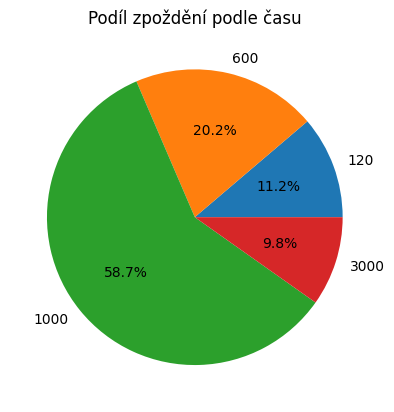

In [17]:
# výběr cyklů se zpožděním
df_delay_sum = (
    df_cycl[df_cycl['stochastic_delay'] > 0]
    .groupby('stochastic_delay')['stochastic_delay']
    .sum()
)

plt.figure()

plt.pie(
    df_delay_sum,
    labels=df_delay_sum.index,
    autopct='%1.1f%%'
)

plt.title("Podíl zpoždění podle času")
plt.show()

### Graf: Kumulativní stochastické zpoždění

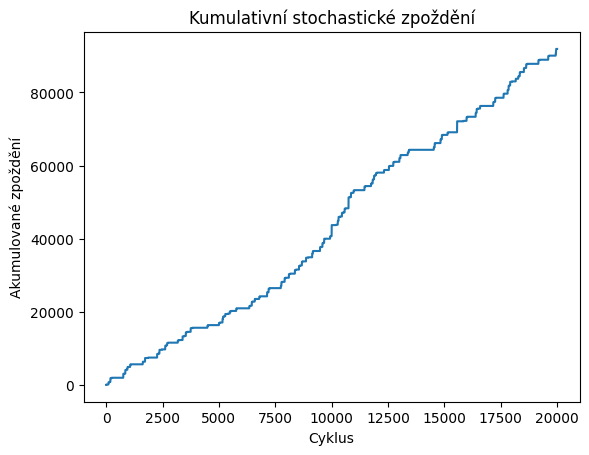

In [18]:
df_cycl = df_cycl.copy()
df_cycl.loc[:, 'cum_delay'] = df_cycl['stochastic_delay'].cumsum()

plt.figure()

plt.plot(df_cycl['cum_delay'])

plt.title("Kumulativní stochastické zpoždění")
plt.xlabel("Cyklus")
plt.ylabel("Akumulované zpoždění")
plt.show()

### Export datové sady do formátu CSV

In [19]:
df_cycl.to_csv('../../data/04_HybridModel/hybrid_model.csv', index=False)

### Autor / Organizace / Datum

Vjačeslav Usmanov, ČVUT v Praze, Fakulta stavební

###### Přehled změn


|  Datum (YYYY-MM-DD) |  Verze | Autor změny  |  Popis změny |
|---|---|---|---|
| 2026-01-27 | 1.1 | Vjačeslav Usmanov| added HM_01_Models_Integration.ipynb |
| 2026-02-16 | 1.2 | Vjačeslav Usmanov| changed HM_01_Models_Integration.ipynb |